In [30]:
import copy
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.special import logsumexp
from shapely.geometry import shape
from scipy.optimize import minimize

%matplotlib inline

# Import data

In [35]:
# Select dataset
dataset = "synthetic" #"synthetic", "retail", "commuter_ward", "commuter_borough"
constrained = "singly"
# R^2 threshold below which R^2 values are not shown
threshold = 0.99

In [36]:
# Import relevant data
origin_supply = np.loadtxt(f'../data/input/{dataset}/origin_supply.txt')
initial_destination_sizes = np.loadtxt(f'../data/input/{dataset}/initial_destination_sizes.txt')
cost_matrix = np.loadtxt(f'../data/input/{dataset}/cost_matrix.txt')

# Define log sizes
xd = np.log(initial_destination_sizes/np.sum(initial_destination_sizes))
# Define normalised cost_matrix
c = cost_matrix/np.sum(cost_matrix)
# Define normalised origin_supply
o = origin_supply/np.sum(origin_supply)

# Define dimensions
N,M = cost_matrix.shape

In [45]:
# Set parameters
alpha = 1.2#1.1
beta = 4.158415841584159
delta = 0 #np.min(np.exp(xd))
gamma = 100
kappa = 1 + delta*M
epsilon = 1


# Define theta
theta = [alpha,beta,delta,gamma,kappa,epsilon]

# Decide on mode (stochastic/deterministic)
if delta == 0:
    mode = 'deterministic'
else:
    mode = 'stochastic'

In [46]:
# Import R^2
r2_values = np.loadtxt(f'../data/output/{dataset}/r_squared/{constrained}_{mode}_rsquared_analysis.txt')
# Import R^2 parameters
with open(f'../data/output/{dataset}/r_squared/figures/{constrained}_{mode}_rsquared_analysis_parameters.json') as json_file:
    r2_values_params = json.load(json_file)

amin = r2_values_params['amin']
amax = r2_values_params['amax']
bmin = r2_values_params['bmin']
bmax = r2_values_params['bmax']
grid_n = r2_values_params['grid_size']
    
alpha_values = np.linspace(amin, amax, grid_n+1)[1:]
beta_values = np.linspace(bmin, bmax, grid_n+1)[1:]
XX, YY = np.meshgrid(alpha_values, beta_values)

# Compute equilibrium point 

This method is based on page 384 of Harris, B., & Wilson, A. G. (1978). Equilibrium Values and Dynamics of Attractiveness Terms in Production-Constrained Spatial-Interaction Models. Environment and Planning A: Economy and Space, 10(4), 371–388. https://doi.org/10.1068/a100371

In [47]:
def deterministic_equilibrium(w0,a,b,T):
    # Initialise inferred W_j's per iteration t
    W = np.empty((M,T+1))
    # Initialise balancing factor
    A = np.empty((N))
    # Initialise inferred flows
    S = np.empty((N,M))
    
    # Initial condition
    W[:,0] = w0
        
    for t in tqdm(range(T)):
        # Update balancing factor
        for i in range(N):
            _sum = 0
            for j in range(M):
                _sum += W[j,t]**(a)*np.exp(-b*c[i,j])
            A[i] = 1./_sum
        # Update estimated flows
        for i in range(N):
            for j in range(M):
                S[i,j] = A[i]*o[i]*W[j,t]**(a)*np.exp(-b*c[i,j])
        # Update W's
        W[:,t] = np.sum(S,axis=0)
    
    return W

In [48]:
w_hat = deterministic_equilibrium((np.exp(xd)),0.5,1.0,10)

  0%|          | 0/10 [00:00<?, ?it/s]/Users/Yannis/.pyenv/versions/stdm/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/Users/Yannis/.pyenv/versions/stdm/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
100%|██████████| 10/10 [00:00<00:00, 1133.50it/s]


# Compute flows and use them to assert model results

In [49]:
# As defined in C function
def _logsumexp(xx):
    _max = xx[0]
    for j in range(M):
        if xx[j] > _max:
            _max = xx[j]

    _sum = 0;
    for j in range(M):
        _sum += np.exp(xx[j] - _max);

    return _max + np.log(_sum)

In [50]:
def pot_value(x,params):
    pot = 1
    a = params[0]
    b = params[1]
    d = params[2]
    g = params[3]
    k = params[4]
    e = params[5]
    a_inv = 1./a
    
    grad = np.zeros(M)
    wksp = np.zeros(M)
    
    utility = 0
    for i in range(N):
        for j in range(M):
            wksp[j] = a*x[j] - b*c[i,j]
        temp = _logsumexp(wksp)

        utility += -e*a_inv*o[i]*temp;
        
        for j in range(M):
            grad[j] += -e*o[i]*np.exp(wksp[j]-temp)
            
    for j in range(M):
        grad[j] += k*np.exp(x[j]) - d
        grad[j] *= g

        
    # Compute cost and additional utilities
    cost = k * np.sum(np.exp(x))
    additional = -d * np.sum(x)

    potential = g*e*(utility+cost+additional)
        
    return potential,grad

In [51]:
def r2(_alpha,_beta,x0,_xd):
    # Change parameter list
    _theta = copy.deepcopy(theta)
    _theta[0] = _alpha
    _theta[1] = _beta
    
    # Maximum likelihood estimated of W_j's
    w_pred = np.exp(_xd)
    
    # Total sum of squares
    w_data = np.exp(xd)
    w_data_centred = w_data - np.mean(w_data)
    ss_tot = np.dot(w_data_centred, w_data_centred)
    # Residual sum of squares
    res = w_pred - w_data
    ss_res = np.dot(res, res)
    
    return (1. - ss_res/ss_tot)

def r2_mle(_alpha,_beta,x0):
    # Change parameter list
    _theta = copy.deepcopy(theta)
    _theta[0] = _alpha
    _theta[1] = _beta
    
    # Maximum likelihood estimated of W_j's
    w_pred = np.exp(minimize(pot_value, x0, method='L-BFGS-B', jac=True, args=(_theta), options={'disp': False}).x)
    
    # Total sum of squares
    w_data = np.exp(xd)
    w_data_centred = w_data - np.mean(w_data)
    ss_tot = np.dot(w_data_centred, w_data_centred)
    # Residual sum of squares
    res = w_pred - w_data
    ss_res = np.dot(res, res)
    
    return (1. - ss_res/ss_tot)

# # Set grid size
# grid_n = 100
# amin,amax = (0,2)
# bmin,bmax = (0,100)
# potentials = np.zeros((grid_n,grid_n))
# r2_values = np.zeros((grid_n, grid_n))

# # Loop and find potential function value for given alphas and betas
# alpha_values = np.linspace(amin, amax, grid_n+1)[1:]
# beta_values = np.linspace(bmin, bmax, grid_n+1)[1:]
# XX, YY = np.meshgrid(alpha_values, beta_values)

# # Total sum squares
# w_data = np.exp(xd)
# w_data_centred = w_data - np.mean(w_data)
# ss_tot = np.dot(w_data_centred, w_data_centred)
# 
# for i in tqdm(range(grid_n)):
#     for j in range(grid_n):
#         theta[0] = XX[i, j]
#         theta[1] = YY[i, j]
#         try:
#             potential,gradient = pot_value(xd,theta)

#     #         print('alpha =',theta[0],'beta =',theta[1],'delta =',theta[2],'gamma =',theta[3],'kappa =',theta[4],'epsilon =',theta[5])
#     #         print('gradient',gradient)
#             w_pred = np.exp(minimize(pot_value, xd, method='L-BFGS-B', jac=True, args=(theta), options={'disp': False}).x)

# #             print(potential)
#             res = w_pred - w_data
#             ss_res = np.dot(res, res)

#             # Regression sum squares
#             r2_values[i, j] = 1. - ss_res/ss_tot

#         except:
#             continue

#         # If minimize fails set value to previous, otherwise update previous
#         if r2_values[i, j] == 0:
#             r2_values[i, j] = last_r2
#             potentials[i, j] = pot_value(np.log(w_pred),theta)[0]
#         else:
#             last_r2 = r2_values[i, j]
#             last_potential = potentials[i, j]

In [52]:
idx = np.unravel_index(r2_values.argmax(), r2_values.shape)

print("Fitted alpha, beta and scaled beta values:")
print(XX[idx], YY[idx], YY[idx]*amax/(bmax))
print("R^2 value:")
print(r2_values[idx])

Fitted alpha, beta and scaled beta values:
1.0 0.12 0.02
R^2 value:
0.9999997373557395


## Find list of optimal parameters in case there are more than one

In [53]:
indices = np.dstack(np.unravel_index(np.argsort(-r2_values.ravel()), (grid_n, grid_n))).reshape(grid_n,grid_n,2)

for n in range(grid_n):
    for m in range(grid_n):
        i = indices[n,m][0]
        j = indices[n,m][1]
        if r2_values[i,j] < threshold:
            break
        print('alpha = ',round(XX[i,j],3),'beta =',round(YY[i,j]*(amax/bmax),3),'scaled beta =',round(YY[i,j],3),'R^2 =',round(r2_values[i,j],9))

alpha =  1.0 beta = 0.02 scaled beta = 0.12 R^2 = 0.999999737


# $R^2$ for given choice of parameters

In [54]:
alpha_test = alpha
beta_test = beta
xd_test = np.ones((M))
# Normalise xd_test
xd_test = np.log(xd_test/np.sum(xd_test))

In [55]:
print(f'alpha = {alpha_test}, beta = {beta_test}, delta = {delta}, gamma = {gamma}, kappa = {kappa}, espilon = {epsilon}')
print('MLE R^2 = ',r2_mle(alpha_test,beta_test,xd))
print('R^2 = ',r2(alpha_test,beta_test,xd,xd_test))

alpha = 1.2, beta = 4.158415841584159, delta = 0, gamma = 100, kappa = 1, espilon = 1
MLE R^2 =  -3.001254593332031
R^2 =  0.0


# Visualise $R^2$

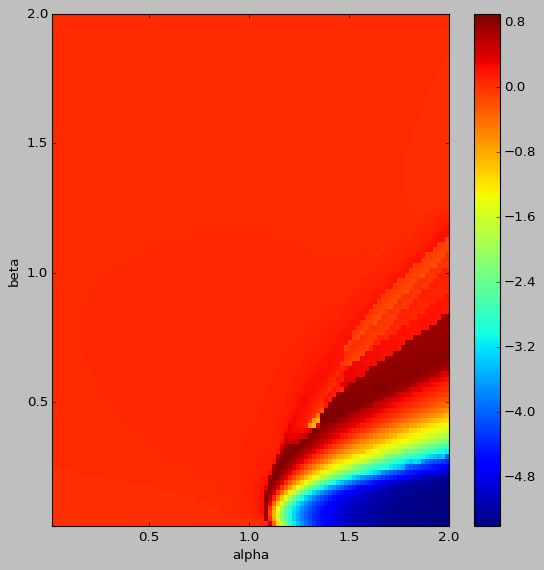

In [20]:
plt.style.use('classic')
fig = plt.figure(figsize=(8,8))
fig.tight_layout(pad=0.5)
plt.pcolor(XX, YY*amax/bmax, r2_values)
plt.xlim([np.min(XX), np.max(XX)])
plt.ylim([np.min(YY)*amax/bmax, np.max(YY)*amax/bmax])
plt.xlabel('alpha')
plt.ylabel('beta')
plt.colorbar()

In [21]:
# Get positive R^2 values
positive_r2_values = copy.deepcopy(r2_values)
positive_r2_values[positive_r2_values<0] = 0

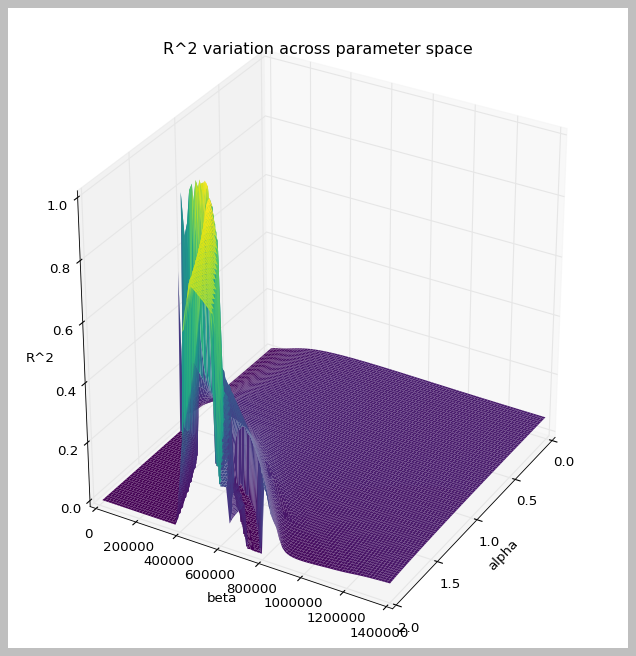

In [29]:
# 3D plot
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')
ax.plot_surface(XX, YY, positive_r2_values, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none')
ax.set_ylabel("beta")
ax.set_xlabel("alpha")
ax.set_zlabel("R^2")
ax.set_title('R^2 variation across parameter space')

ax.view_init(30, 30)

# Compute flows

In [261]:
# Initialise flows
T = np.loadtxt(f'../data/input/{dataset}/od_matrix.txt') #np.zeros((N,M))
That = np.zeros((N,M))

# Read optimal parameters
with open(f'../data/output/{dataset}/r_squared/figures/{constrained}_{mode}_rsquared_analysis_gamma_{str(gamma)}_parameters.json') as json_file:
    params = json.load(json_file)
    
alpha = params['fitted_alpha']
beta = params['fitted_beta']#*(params['bmax']/params['amax'])

# Update parameters to fitted values
theta[0] = alpha
theta[1] = beta

# Get best predictions
what = np.exp(minimize(pot_value, xd, method='L-BFGS-B', jac=True, args=(theta), options={'disp': False}).x)
xhat = np.log(what)

In [262]:
what

array([0.72781893, 0.27218079])

In [263]:
np.exp(xd)

array([0.72727273, 0.27272727])

In [264]:
correlation_matrix = np.corrcoef(what, np.exp(xd))
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2

In [265]:
# Construct flow matrix
for i in range(N):
    for j in range(M):
        _sum = 0
        _sum_hat = 0 
        for jj in range(M):
            _sum += np.exp(alpha*xd[j]-beta*c[i,jj])
            _sum_hat += np.exp(XX[idx]*xhat[j]-YY[idx]*c[i,jj])
            
#         T[i,j] = o[i]*np.exp(alpha*xd[j]-beta*c[i,j]) / _sum
        
        That[i,j] = o[i]*np.exp(XX[idx]*xhat[j]-YY[idx]*c[i,j]) / _sum_hat

In [266]:
That

array([[0.23055744, 0.06944256],
       [0.25      , 0.25      ],
       [0.04629504, 0.15370496]])

In [267]:
T

array([[0.26107962, 0.03892039],
       [0.36345701, 0.13654299],
       [0.10273611, 0.09726389]])

In [268]:
np.sum(That,axis=0)

array([0.52685248, 0.47314752])

In [269]:
np.sum(T,axis=0)

array([0.72727273, 0.27272727])

In [270]:
np.sum((T-That)**2)

0.033979379201106795